# Bayesian classification using spark

Here I will use bayesian classification using spark.

## First check how data is distributed across dataset

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


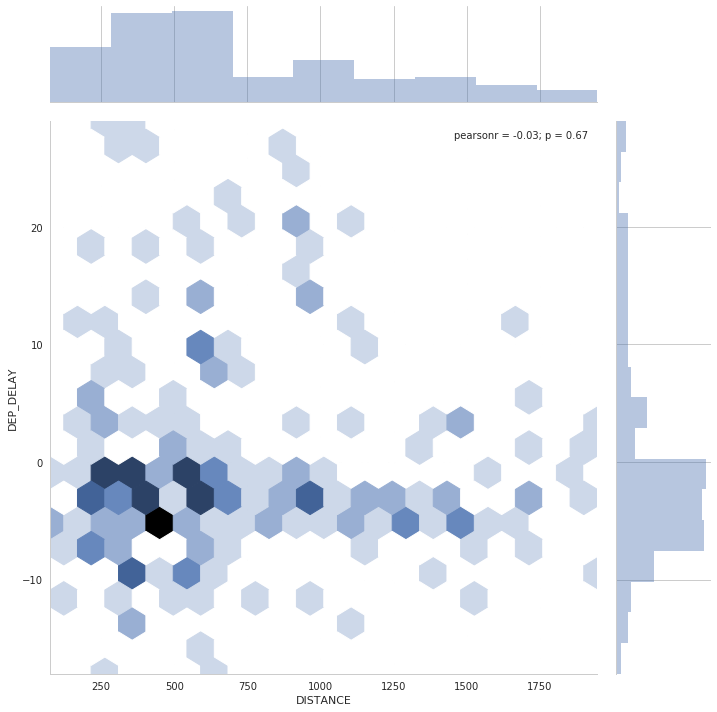

In [22]:
import seaborn as sb
import google.datalab.bigquery as bq

sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20
  AND dep_delay < 30 AND distance < 2000
"""

df = bq.Query(sql).execute().result().to_dataframe()
sb.set_style("whitegrid")

# Examples 
# With hexagon plot
g = sb.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind='hex', size=10, joint_kws={'gridsize': 20})

## Prepare environment variables

In [6]:
%env PROJECT=elite-caster-125113

env: PROJECT=elite-caster-125113


In [23]:
%env GS_TZCORR_FLIGHT=flights/output/events-*

env: GS_TZCORR_FLIGHT=flights/output/events-*


## Check spark version

In [7]:
%bash
spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.3.4
      /_/
                        
Using Scala version 2.11.8, OpenJDK 64-Bit Server VM, 1.8.0_252
Branch HEAD
Compiled by user  on 2020-04-01T12:17:00Z
Revision d52bf2785a4363f4954c32bc612ba484dd385ccb
Url https://bigdataoss-internal.googlesource.com/third_party/apache/spark
Type --help for more information.


## Prepare required libraries

In [8]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import *

## Configure spark
Skip this phase when using data initialized with google script. I wrote this for practice

gs://dataproc-initialization-actions/datalab/datalab.sh

In [9]:
"""
SparkConf  
https://spark.apache.org/docs/SPARKVERSION/api/python/pyspark.html#pyspark.SparkConf

Property list
https://spark.apache.org/docs/SPARKVERSION/configuration.html
"""

# Write properties here
conf = [
  ("spark.app.name", "Bayes classification using Spark"),
  ("spark.master", "local")
]

s_conf=SparkConf() \
    .setAll(conf)

## Initilaize spark session
We will use SparkSession to create entry point to access Dataset and Dataframe APIs.

In [10]:
"""
SparkSession
https://spark.apache.org/docs/SPARKVERSION/api/python/pyspark.sql.html#pyspark.sql.SparkSession
"""
s_session = SparkSession \
    .builder \
    .config(conf=s_conf) \
    .getOrCreate()

## Define schema for parsing csv lines extracted from spark
Quantize distance , arrival delay, departure delay to carry out classification .

In [16]:
"""
StructField
https://spark.apache.org/docs/SPARKVERSION/api/python/pyspark.sql.html#pyspark.sql.types.StructField

StructType
https://spark.apache.org/docs/SPARKVERSION/api/python/pyspark.sql.html?highlight=sparksession#pyspark.sql.types.StructType
"""

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
  # Tell spark to recognize the column as correct type instead of string
  if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
    return StructField(colname, FloatType(), True)
  else:
    return StructField(colname, StringType(), True)

schema=StructType([get_structfield(col) for col in header.split(',')])

## Import sample flight data

In [28]:

project=os.getenv('PROJECT')
gs_path=os.getenv('GS_TZCORR_FLIGHT')

inputs='gs://{}/{}'.format(project, gs_path)

# Read data from spark
flights = s_session.read \
    .schema(schema) \
    .csv(inputs)

## Create view to use spark sql

In [29]:
flights.createOrReplaceTempView('flights')

In [33]:
# Here I will check count of rows in the view to make sure view is working.
sql = 'SELECT COUNT(*) FROM flights'

results = s_session.sql(sql)
results.show()

+--------+
|count(1)|
+--------+
| 3351992|
+--------+



In [34]:
# Again, I will check row count but this time show counts 
# that are departure delay higher than -20, flight distance less than 2000
sql = 'SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 2000'

results = s_session.sql(sql)
results.show()

+--------+
|count(1)|
+--------+
| 1037896|
+--------+

